# Pairs Trading of Pfizer and Merck 

Stock background info:
- I will be comparing Merck and Pfizer Stocks
- Merck:
    - Has slipped in the past year 
    - Could be on the uptic with efforts to produce a COVID Vaccine 
    - Is teaming up with the Non-Profit IAVI (International Aids Vaccine Initiative) in order to get a vaccine
- Pfizer:
    - Has been on the uptic, reported profits higher than expected
    - Has reported promising results with COVID vaccine 
    - They are in the late stage trials for the vaccine 

     
     

Pairs Trading Explained:
    - Strategy to trade stocks 
    - Take opposite postion in two related stocks (in this case drug companies)  
    - Pivot between postion to make profit
 
    Pros:
        - Done correctly can profit no matter what if the two stocks are correlated 
        - Can mitigare risk
    Cons:
        - Chance that stocks are not correlated, relationship could break down
        

In [5]:
from sklearn.svm import SVR
import pandas as pd
import csv
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import scipy 
from scipy.stats import norm
import datetime
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import quandl 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime
import os
from empyrical import max_drawdown, alpha_beta
tf.compat.v1.disable_eager_execution()
os.chdir('Documents')

# Clean The Data

In [6]:
#MERCK data
merck_close = quandl.get("EOD/MRK", authtoken="NBLgPzpuGoHfAHnzrE2x")['Adj_Close']
#PFIZER Data 
pfizer_close = quandl.get("EOD/PFE", authtoken="NBLgPzpuGoHfAHnzrE2x")['Adj_Close']
total_close = pfizer_close - merck_close 

#Importing the NYSE Pharma Index to use as a benchmark
risk = pd.read_csv('NYSE_PHARMA.csv')
risk = np.array(risk)

In [7]:
#Clean data together 
drug = pd.concat([merck_close, pfizer_close], axis = 1)
drug.columns = [''] * len(drug.columns)
drug.columns = ['Merck', 'Pfizer']
drug_raw = drug
drug_raw2 = drug.copy()
#add difference column between pfizer and merck stock to dataframe
drug_raw2['Pfizer - Merck'] = drug_raw2['Pfizer'] - drug_raw2['Merck']
#we can see that Pfizer - Merck is negative which means Merck is almost always higher than Pfizer
#This is of no consequence
print(drug_raw2)

                Merck     Pfizer  Pfizer - Merck
Date                                            
2013-09-03  38.021225  21.747410      -16.273815
2013-09-04  38.399746  22.026920      -16.372826
2013-09-05  38.262834  21.949278      -16.313556
2013-09-06  38.246727  21.957042      -16.289685
2013-09-09  38.448068  21.972571      -16.475497
...               ...        ...             ...
2017-12-21  52.606497  32.737747      -19.868750
2017-12-22  52.383430  32.647411      -19.736020
2017-12-26  52.364842  32.710646      -19.654196
2017-12-27  52.364842  32.819049      -19.545793
2017-12-28  52.606497  32.855183      -19.751314

[1090 rows x 3 columns]


We will be examining the adjusted closing prices for both Pfizer and Merck 

# Vizualization of Trend of Adjusted Closing Price of Data

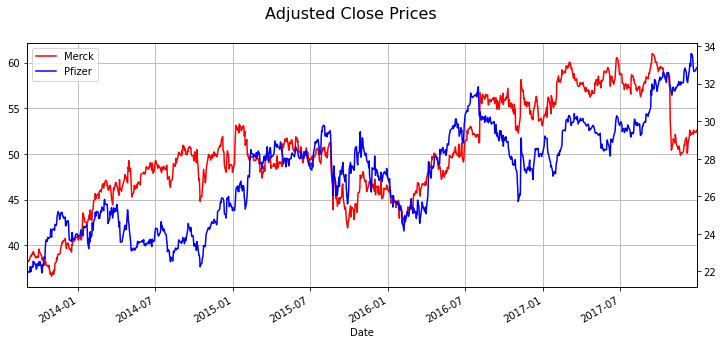

In [8]:
#Vizualize trend of data in matplotlib  
plt.figure(figsize=(12,5))
ax1 = drug_raw2['Merck'].plot(color='red', grid=True, label='Merck')
ax2 = drug_raw2['Pfizer'].plot(color='blue', grid=True, secondary_y=True, label='Pfizer')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.suptitle('Adjusted Close Prices', fontsize=16)
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

#  Statistical Measurements of Data

In [9]:
#This is very important because this is helping to validate our trading strategy
#If the correlation and cointegration are low then our strategy will most likely not be good
def get_stats(set1, set2):
    mean_set1 = set1.mean()
    mean_set2 = set2.mean()
    stand_dev1 = set1.std()
    stand_dev2 = set2.std()
    get_stats = ((set1*set2).mean() - mean_set1*mean_set2)/(stand_dev1*stand_dev2)
    return get_stats
merck = 'Merck'
pfizer = 'Pfizer'

score, pvalue, _= coint(drug_raw2[merck], drug_raw2[pfizer])
correlate = get_stats(drug_raw2[merck], drug_raw2[pfizer])

print('Correlation between %s and %s is %f' % (merck, pfizer, correlate))
print('Cointegration between %s and %s is %f' % (merck, pfizer, pvalue))

Correlation between Merck and Pfizer is 0.706717
Cointegration between Merck and Pfizer is 0.520267


The correlation and cointegration are rather high between these two stocks which is good because it helps to validate our trading strategy between these two stocks

# Risk and Sharpe Ratio of Pfizer and Merck Stocks 

In [10]:
#Put both adjusted closes into numpy arrays
#Merck
merck_close = np.array(merck_close)
#Pfizer 
pfizer_close = np.array(pfizer_close)

In [11]:
#Merck alpha and beta
max_drawdown(merck_close)
alpha, beta = alpha_beta(merck_close, risk)
print(alpha)
print(beta)

2.9486635627319866e+173
0.0649031907624724


/Users/gabesmithline/anaconda3/lib/python3.6/site-packages/empyrical/stats.py:265: RuntimeWarning: overflow encountered in multiply
  np.multiply(out, starting_value, out=out)
/Users/gabesmithline/anaconda3/lib/python3.6/site-packages/empyrical/stats.py:394: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)


In [12]:
#Pfizer alpha and beta
max_drawdown(pfizer_close)
alpha, beta = alpha_beta(pfizer_close, risk)
print(alpha)
print(beta)

inf
0.006642423295626004


/Users/gabesmithline/anaconda3/lib/python3.6/site-packages/empyrical/stats.py:1294: RuntimeWarning: overflow encountered in power
  out=out


In [13]:
#sharpe ratio for Merck
def sharpe(returns, N=30):
    """
    Calculate the  Sharpe ratio of a returns stream 
    based on a number of trading periods, N. N defaults to 30,
    which then assumes a stream of daily returns.

    The function assumes that the returns are the excess of 
    those compared to a benchmark.
    """
    return np.sqrt(N) * returns.mean() / returns.std()

final = sharpe(merck_close)
print(final)

48.943695923111505


In [14]:
#sharpe ratio for Pfizer 
def sharpe(returns, N=30):
    """
    Calculate the  Sharpe ratio of a returns stream 
    based on a number of trading periods, N. N defaults to 30,
    which then assumes a stream of daily returns.

    The function assumes that the returns are the excess of 
    those compared to a benchmark.
    """
    return np.sqrt(N) * (returns.mean() / returns.std())

final2 = sharpe(pfizer_close)
print(final2)

54.914323535155084


Alpha measures the amount an investment has returned in comparison to the market.  It is indicated by a single number and the higher it is above zero the better the stock has performed in comparison to the market. In both cases our alphas are higher then the market so our stocks are expected to outperfom our benchmark index (the NYSE Pharma Index). 

Beta measures the volatility of the stock or fund in comparison to some benchmark.  Beta is meant to let help the investor decide if it is worth taking on the risk. As the beta gets less than one the stock/fund is considered less volatile and risk, as it goes above 1 it is considered more volatile and risky.  As one can see both of our Beta's are below one and almost 0, meaning these stocks are considered not very volatile in comparison to our benchmark.  

Sharpe ratio is a ratio to help investors better understand their their return on investment in comparison to their risk.  THe ratio is the Return of the portfolio minus the risk free rate of return and then all that divided by the standard deviation of the portfolio or stocks return.  The higher and more positive the Sharpe ratio the better its risk adjusted performance, if it is negative this means that either the risk free rate is higher than the expected return or the expected return is expected to be negative.  In our case we see a positive Sharpe ratio which is good, on paper it has a good risk adjusted performance.

# Graph of Difference in Stock Prices (Merck - Pfizer)

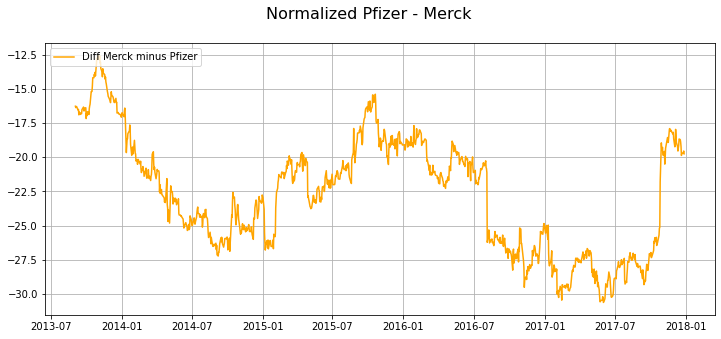

In [15]:
#Here is just a graph of Pfizer - Merck
#If we can predict this difference we can pivot our positions between the two stock to benefit
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(drug_raw2['Pfizer'] - drug_raw2['Merck'], color='orange', label='Diff Merck minus Pfizer')
ax.grid(True) 
plt.suptitle('Normalized Pfizer - Merck', fontsize=16)
plt.legend(loc=2)
plt.show()

# Predictive Model

We will be trying to use an SVM to help predict the difference in the Pfizer in Merck stocks, this information will help us to understand which of these two stocks we should short or long in a pairs trading strategy.

A Support Vector Machine is a type of supervised machine learning model.  It works by trying to find a hyperlane in 'N' dimensional space that will uniquely classify the data points. Hyperlanes are boundaries that work to help us classify the data points, data points fall to a side of the hyperplane based on their classification. 

In our case we are using a specific type of Support Vector Machine, a Support Vector Regression or SVR. SVR is a regression algorithm, it utilizes kernels, sparse solution, and control of the margin of support vectors. 



# Break up the data and train the model 

In [16]:
#forecast_out is how many days in the future our prediction will run
#in this case our model will predict 30 days into the future
forecast_out = 30
#We add the prediction column then remove the last forecast_out days
drug_raw2['Prediction'] = drug_raw2[['Pfizer - Merck']].shift(-forecast_out)
print(drug_raw2)

                Merck     Pfizer  Pfizer - Merck  Prediction
Date                                                        
2013-09-03  38.021225  21.747410      -16.273815  -15.202547
2013-09-04  38.399746  22.026920      -16.372826  -15.193201
2013-09-05  38.262834  21.949278      -16.313556  -14.787294
2013-09-06  38.246727  21.957042      -16.289685  -14.186889
2013-09-09  38.448068  21.972571      -16.475497  -14.191035
...               ...        ...             ...         ...
2017-12-21  52.606497  32.737747      -19.868750         NaN
2017-12-22  52.383430  32.647411      -19.736020         NaN
2017-12-26  52.364842  32.710646      -19.654196         NaN
2017-12-27  52.364842  32.819049      -19.545793         NaN
2017-12-28  52.606497  32.855183      -19.751314         NaN

[1090 rows x 4 columns]


In [17]:
#droping the last 30 days so we can use our model to predict them
#if we change the value of forecast_out we change the number of days out our model goes, in our case 30 days
X= np.array(drug_raw2.drop(['Prediction'],1))
X = X[:-forecast_out]
#getting all the y values then dropping the last forecast_out rows
#Same as above but for y values
y = np.array(drug_raw2['Prediction'])
y =  y[:-forecast_out]
print(y)

[-15.20254658 -15.19320107 -14.78729368 ... -19.65419585 -19.54579271
 -19.75131362]


In [18]:
#Spliting up the data into training and and testing data
#80% of the data is training and 20% is testing
train1, x_test1 , y_train1, y_test1 = train_test_split(X, y, test_size = .2)

In [19]:
#SVR for model of Pfizer - Merck 
svr_rbf = SVR(kernel='rbf', C=1e3, gamma = .1)
svr_rbf.fit(train1, y_train1)

SVR(C=1000.0, gamma=0.1)

In [20]:
#The test model below returns the score of accuracy of prediction
#It is just an R^2 value
#Highest score is 1
#We have about 91.5% (.915) which is very good, we know this model is a storng fit
svm_con = svr_rbf.score(x_test1, y_test1)
print(svm_con)

0.915114437791301


In [21]:
#We will also check a linear regression model to see its fit
#Its important to evaluate at least some other models before you pick one
#Create and train lin reg model 
lr = LinearRegression()
#Train
lr.fit(train1, y_train1)

LinearRegression()

In [22]:
#Test model above, score returns accuracy of prediction
#Highest score is 1
#As we can see it is a much lower score than the SVR Model
#We will choose the SVR model for vizualization and prediction
lr_con = lr.score(x_test1, y_test1)
print(lr_con)

0.6566881877321527


In [23]:
#Set x_forecast equal to forecast_out of the original data
x_forecast = np.array(drug_raw2.drop(['Prediction'],1))[-forecast_out:]
print(x_forecast)

[[ 50.5007128   31.94279023 -18.55792256]
 [ 50.84168476  32.12346212 -18.71822264]
 [ 50.86933114  31.95182383 -18.91750731]
 [ 49.8556307   31.93375664 -17.92187406]
 [ 50.01229349  32.10539493 -17.90689856]
 [ 50.10444808  32.00602539 -18.09842268]
 [ 50.08601716  32.06022696 -18.0257902 ]
 [ 50.27032633  32.06022696 -18.21009937]
 [ 50.62051376  32.38543636 -18.23507739]
 [ 51.01677847  32.71064577 -18.30613271]
 [ 50.93383935  32.75581374 -18.17802561]
 [ 51.48676686  32.83711609 -18.64965077]
 [ 51.80930791  32.57514185 -19.23416606]
 [ 51.39461227  32.18669728 -19.20791499]
 [ 50.08601716  32.12346212 -17.96255504]
 [ 50.47306642  32.06926056 -18.40380586]
 [ 51.2103031   32.28606682 -18.92423628]
 [ 51.91989341  32.71064577 -19.20924764]
 [ 52.59262188  33.04488876 -19.54773312]
 [ 52.44517455  33.09909033 -19.34608422]
 [ 52.05812529  32.93648563 -19.12163966]
 [ 52.27189727  33.60497162 -18.66692565]
 [ 52.2533084   33.54173646 -18.71157194]
 [ 52.26260284  33.37009817 -18.89

In [24]:
#SVR which is 90% accurate
#The actual values are not necessarily what is most important, rather it is the trend
#Here are the 30 predicted values
#The trend is graphed below of the entire set including the 30 predicted values are graphed below
svm_predict = svr_rbf.predict(x_forecast)
print(svm_predict)

[-20.8660849  -19.76898793 -18.83489492 -26.50811105 -27.02053345
 -24.84101986 -25.67493444 -23.86305853 -24.44071831 -24.72005137
 -26.47867307 -20.72211987 -15.53667246 -17.14346377 -26.48169946
 -22.13900644 -18.28607469 -15.23344716 -12.21815833 -13.25897539
 -15.39858831 -21.20167257 -20.46041705 -17.78383585 -14.57260968
 -12.5804635  -13.18337834 -13.00914179 -12.87783087 -12.16606268]


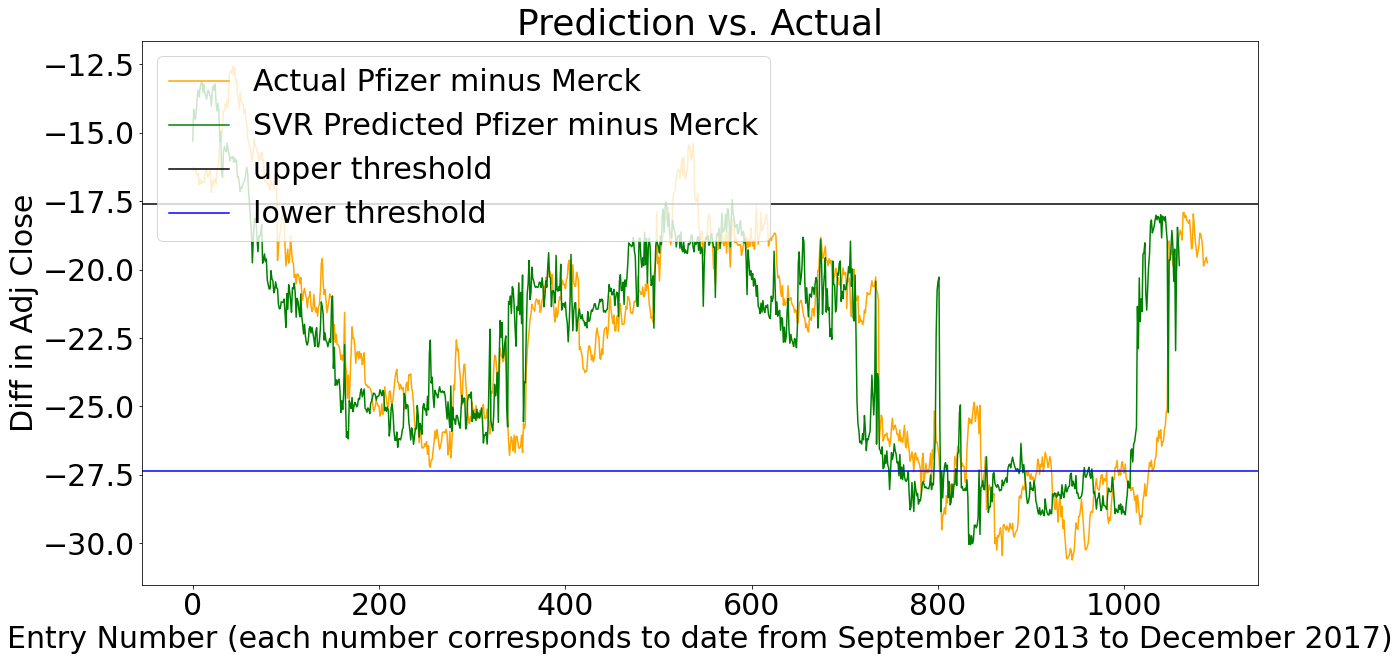

In [29]:
#The actual trend of Pfizer - Merck is in orange
#The predicted trend of Pfizer - Merck is in green
#An explanation is below
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(drug_raw2['Pfizer - Merck'].to_numpy(), color='orange', label='Actual Pfizer minus Merck')
plt.plot(svr_rbf.predict(X), color = 'Green', label = 'SVR Predicted Pfizer minus Merck')
plt.title('Prediction vs. Actual')
#The higher the entry the later the date 
plt.xlabel('Entry Number (each number corresponds to date from September 2013 to December 2017)')
plt.ylabel('Diff in Adj Close')
plt.axhline(y = (-4.5*np.std(svr_rbf.predict(X))), color = 'Black', label = 'upper threshold')
plt.axhline(y = (-7*np.std(svr_rbf.predict(X))), color = 'blue', label = 'lower threshold')
plt.legend(loc=2)
plt.rcParams.update({'font.size': 30})
plt.show()

In orange we see the actual difference in the adjusted closing prices of Pfizer and Merck Stock (Pfizer - Merck) and in green we see the prediction of this difference using the SVR model.  

As the trend gets more negative the difference between the Pfizer and Merck stocks gets larger and larger, likewise as it gets more positive this is an indication that the stock prices are getting closer together. If there is a high negative value this is an indiction that either Pfizer has dropped or Merck has risen, which in turn might mean we should short Merck and long Pfizer.  If there is a more positive value this is an indication that either Pfizer has risen or Merck has dropped, which in turn means we should flip by going short on Pfizer and long on Merck. In pairs trading we are trying to capitilize by pivoting our position between the two stocks, by being able to predict when to long one stock, short another and vice versa one will be able to profit more. 

This is a tool like anything in data science, it should not be solely relied upon, but if one can use this model and stategy correctly in conjunction with other tools it can be very powerful. 




# Evaluating Further Using an LSTM Model To Predict 30 Days Into the Future  

Using another tool in our arsenal to predict the effectiveness of our strategy and further validate the points above we will use an LSTM model. An LSTM Model, or Long Short Term Memory Model is a type of recurrent neural network (or RNN for short).  An LSTM model is a special type of RNN that is capable of learning long term dependencies. LSTMs are very well suited for time series data which makes it particullary attractive for our data.

Both SVR and LSTM models are great tools.  But is one better? Well that depends.  LSTMs always consider long term dependencies and evalute a new value after understanding the whole pattern in the series.  SVRs consider each row as a part of training data and will predict the outcome without considering previous patterns.  If you have "enough data" LSTM models are considered best however in many cases SVRs will perform better due to a small data size. 

Because it is not entirely clear what is "enough" I have decided to further test my strategy in an LSTM model.  If it performs similiar to the SVR model then I have much greater confidence.

In [30]:
#Reshaping my data to fit the LSTM model
scaler=MinMaxScaler(feature_range=(0,1))
total_close=scaler.fit_transform(np.array(total_close).reshape(-1,1))

In [31]:
#splitting dataset into train and test split
training_size=int(len(total_close)*0.65)
test_size=len(total_close)-training_size
train_data2,test_data2=total_close[0:training_size,:],total_close[training_size:len(total_close),:1]

In [32]:
#Getting the size and dimensions of the data
training_size,test_size

(708, 382)

In [33]:
#The actual training data for the model
train_data2

array([[0.79401151],
       [0.78853004],
       [0.79181136],
       [0.79313293],
       [0.78284596],
       [0.77859277],
       [0.78091539],
       [0.75919902],
       [0.77049506],
       [0.76109694],
       [0.76618578],
       [0.76583433],
       [0.76376069],
       [0.7803705 ],
       [0.78790903],
       [0.79078856],
       [0.77503386],
       [0.7758735 ],
       [0.78639914],
       [0.78787932],
       [0.74409105],
       [0.76589443],
       [0.75602814],
       [0.77176281],
       [0.77072457],
       [0.76068887],
       [0.78443197],
       [0.79516709],
       [0.80201535],
       [0.85338842],
       [0.85331917],
       [0.85383655],
       [0.87630844],
       [0.90954809],
       [0.90931857],
       [0.92315359],
       [0.91566601],
       [0.93139153],
       [0.9169956 ],
       [0.9761184 ],
       [0.98769317],
       [0.98923397],
       [0.98545098],
       [1.        ],
       [0.98182479],
       [0.99716053],
       [0.96887863],
       [0.972

In [34]:
#converting the array of values into a dataset matrix
#needed to model the data
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [35]:
#breaking up the data into x-traing/testing data and y-training/testing data
time_step = 100
X_train, y_train = create_dataset(train_data2, time_step)
X_test, ytest = create_dataset(test_data2, time_step)

In [36]:
#getting the shape of the x and y shapes of the metrics 
print(X_train.shape), print(y_train.shape)

(607, 100)
(607,)


(None, None)

In [37]:
#reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:
#Create the Stacked LSTM model
#Uploading the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [39]:
#Building the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [40]:
#Fitting the data to the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=110,batch_size=64,verbose=1)

Train on 607 samples, validate on 281 samples
Epoch 1/110
607/607 [==============================] - 2s 3ms/sample - loss: 0.0865 - val_loss: 0.0195
Epoch 2/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0126 - val_loss: 0.0167
Epoch 3/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0073 - val_loss: 0.0166
Epoch 4/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0064 - val_loss: 0.0159
Epoch 5/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0057 - val_loss: 0.0126
Epoch 6/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0050 - val_loss: 0.0110
Epoch 7/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0046 - val_loss: 0.0096
Epoch 8/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0043 - val_loss: 0.0083
Epoch 9/110
607/607 [==============================] - 1s 2ms/sample - loss: 0.0041 - val_loss: 0.0077
Epoch 10/110
607/607 [=====

In [41]:
#checking our prediction and performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [42]:
# Training RMSE performance metrics
#import math
#from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.028586377946373524

In [43]:
# Test Data RMSE performance metrics 
math.sqrt(mean_squared_error(ytest,test_predict))

0.03928944706175632

The RMSE or Root Mean Squared Error is a measure of difference between values predicted by the model and the observed values. Generally speaking the lower the RMSE value the better, it predicts how exactly the model predicts the response and here we see both for the training and test data very small RMSE values. This is a strong indictor of the model.

In [44]:
#reshaping the x data input 
x_input=test_data2[282:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [45]:
#prediction for the next 30 days 
#cleaning the data for vizualization 
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

day_new=np.arange(1,101)
day_pred=np.arange(101,131)

[0.60797083]
101
1 day input [0.1871333  0.20135063 0.18279349 0.17107617 0.18315742 0.17203448
 0.19528074 0.19913409 0.17927847 0.17581101 0.19394935 0.16508492
 0.16136325 0.14607788 0.15769644 0.15521838 0.14102482 0.14452703
 0.14723553 0.13740191 0.12119116 0.12917583 0.09651292 0.13183495
 0.11697753 0.09243279 0.07205436 0.09014419 0.08722881 0.12215491
 0.13085723 0.15434041 0.12948689 0.14050687 0.15763462 0.17935405
 0.19757505 0.189383   0.20203566 0.18138033 0.18336278 0.18839178
 0.20407641 0.21032992 0.2475007  0.23999364 0.26194625 0.24665512
 0.26368085 0.23054774 0.23862339 0.24091199 0.26440975 0.2727622
 0.3009828  0.30363565 0.48801721 0.64581064 0.62196302 0.6191206
 0.62750231 0.59675992 0.59454418 0.61132206 0.55982232 0.58762027
 0.62386369 0.64925222 0.65886523 0.66755854 0.658684   0.64765118
 0.70277152 0.70360059 0.69299742 0.6970185  0.68681476 0.68543193
 0.68149816 0.68859043 0.66248028 0.63012029 0.63157361 0.70051933
 0.67609077 0.64727865 0.63149983 0

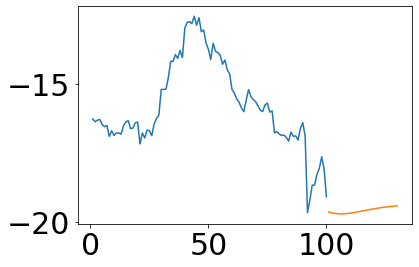

In [46]:
#A plot of the difference between Pfizer and Merck stock in blue
#In orange a 30 day prediction of the difference between these two stocks
plt.plot(day_new,scaler.inverse_transform(total_close[:100]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

We see in blue the actual data then in orange we see the next 30 days.  We see the difference between the Pfizer and Merck Stock getting more positive.  If you look above at our predicted SVR model in green you'll see that the difference between the two stocks is also getting more positive towards the end there.  Like I stated above this is an indication of a convergence of the two stocks and means that either Pfizer is going down and Merck is going down, Merck is going up and Pfizer is also rising, or Merck is falling and Pfizer is rising. Either way it is a strong indication that we need to pivot our stance in our strategy. 